<a href="https://colab.research.google.com/github/d0lev/API-Security-Detection/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install uuid
!pip install lief==0.11.5

In [2]:
import uuid
import json
import lief
import pandas as pd
from pprint import pprint
import os
from IPython.display import HTML

## Preprocessing :
---
At this stage we will preprocess the raw data which represented as Mach-O file format.
Since both classes contain binary files, we will use a library that handles those files called `LIEF`. You can found the documentation [here](https://lief-project.github.io/doc/stable/api/python/macho.html) .



### Mach-O file as JSON object :

The parsing result of each file is converted into a JSON object which is much easier to deal with to extract the relevant features from each file , As a result, each JSON file will look like this :




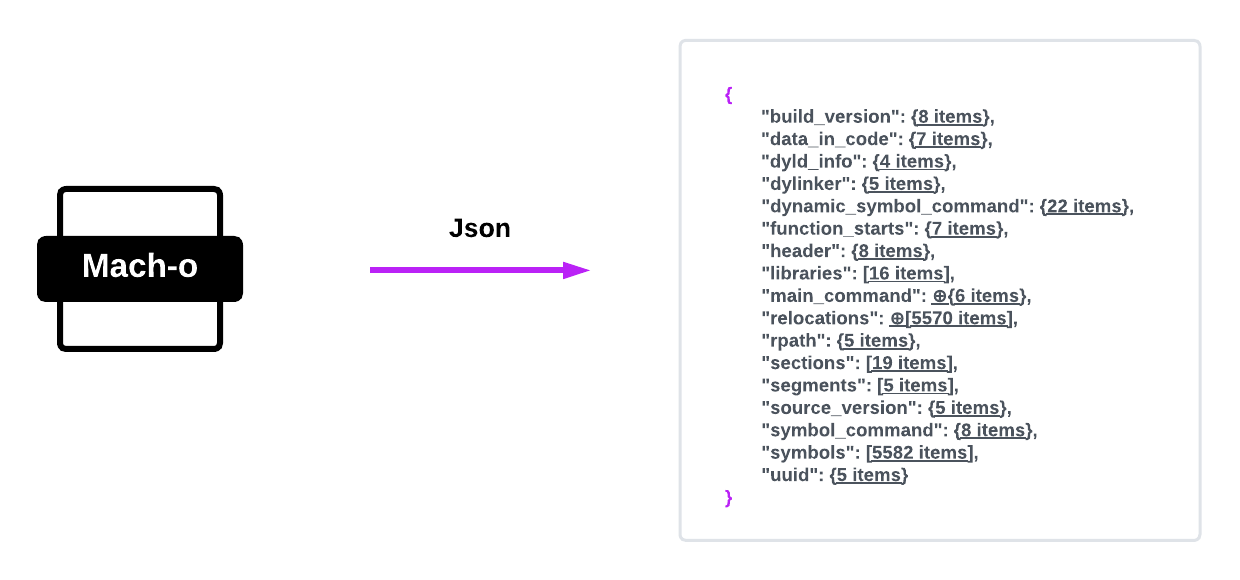

After converting each binary file to a JSON file, we created a DataFrame which will contain records that represents those files.
As you can see, for each JSON file there are 17 keys and they have different values. The same keys will be the columns of the raw dataset.

In [3]:
def get_raw_dataset(dataset_type):
  directory = '/content/drive/MyDrive/MacOSMalware/' + dataset_type
  # Create a raw data set that will contain records describing Mach-O files as JSON objects.
  dataset = pd.DataFrame()
  for filename in os.listdir(directory):
      macho_file = os.path.join(directory, filename)
      binary = lief.parse(macho_file)
      binary_json = json.loads(lief.to_json(binary))
      row = pd.Series(binary_json)
      dataset = dataset.append(row , ignore_index = True)
  return dataset

In [ ]:
raw_benign = get_raw_dataset("Benigns")
raw_malware = get_raw_dataset("Malwares")

# Since parsing takes quite a long time, we will keep the raw data sets for now.
raw_benign.to_csv("/content/drive/MyDrive/MacOSMalware/raw_benign.csv")
raw_malware.to_csv("/content/drive/MyDrive/MacOSMalware/raw_malwares.csv")

In [4]:
raw_benign = pd.read_csv("/content/drive/MyDrive/MacOSMalware/raw_benign.csv" , index_col = 0)
raw_malware = pd.read_csv("/content/drive/MyDrive/MacOSMalware/raw_malwares.csv" , index_col = 0)

In [6]:
raw_benign.head(1)

,code_signature,data_in_code,dyld_info,dylinker,dynamic_symbol_command,function_starts,header,libraries,main_command,relocations,rpath,sections,segments,source_version,symbol_command,symbols,uuid,version_min,build_version,thread_command
0,"{'command': 'CODE_SIGNATURE', 'command_offset'...","{'command': 'DATA_IN_CODE', 'command_offset': ...","{'command': 'DYLD_INFO_ONLY', 'command_offset'...","{'command': 'LOAD_DYLINKER', 'command_offset':...","{'command': 'DYSYMTAB', 'command_offset': 2312...","{'command': 'FUNCTION_STARTS', 'command_offset...","{'cpu_subtype': 2147483651, 'cpu_type': 'x86_6...","[{'command': 'LOAD_DYLIB', 'command_offset': 2...","{'command': 'MAIN', 'command_offset': 2480, 'c...","[{'architecture': 'x86_64', 'is_pc_relative': ...","{'command': 'RPATH', 'command_offset': 3760, '...","[{'alignment': 4, 'content_hash': 184467440731...","[{'command': 'SEGMENT_64', 'command_offset': 3...","{'command': 'SOURCE_VERSION', 'command_offset'...","{'command': 'SYMTAB', 'command_offset': 2288, ...","[{'description': 0, 'is_external': False, 'nam...","{'command': 'UUID', 'command_offset': 2424, 'c...","{'command': 'VERSION_MIN_MACOSX', 'command_off...",NaN,NaN


### Extracting Raw Features :

Now, we have a raw data set in which each record represents a JSON file describing a binary Mach-O file.
There are 17 columns, and each column contains the value according to the corresponding key in the file, those values can be lists, strings, numbers, and dictionaries.
Therefore we will have to produce a generic data set so that each column in the data set will be identical to the subkeys of each JSON object which will contain its corresponding value.

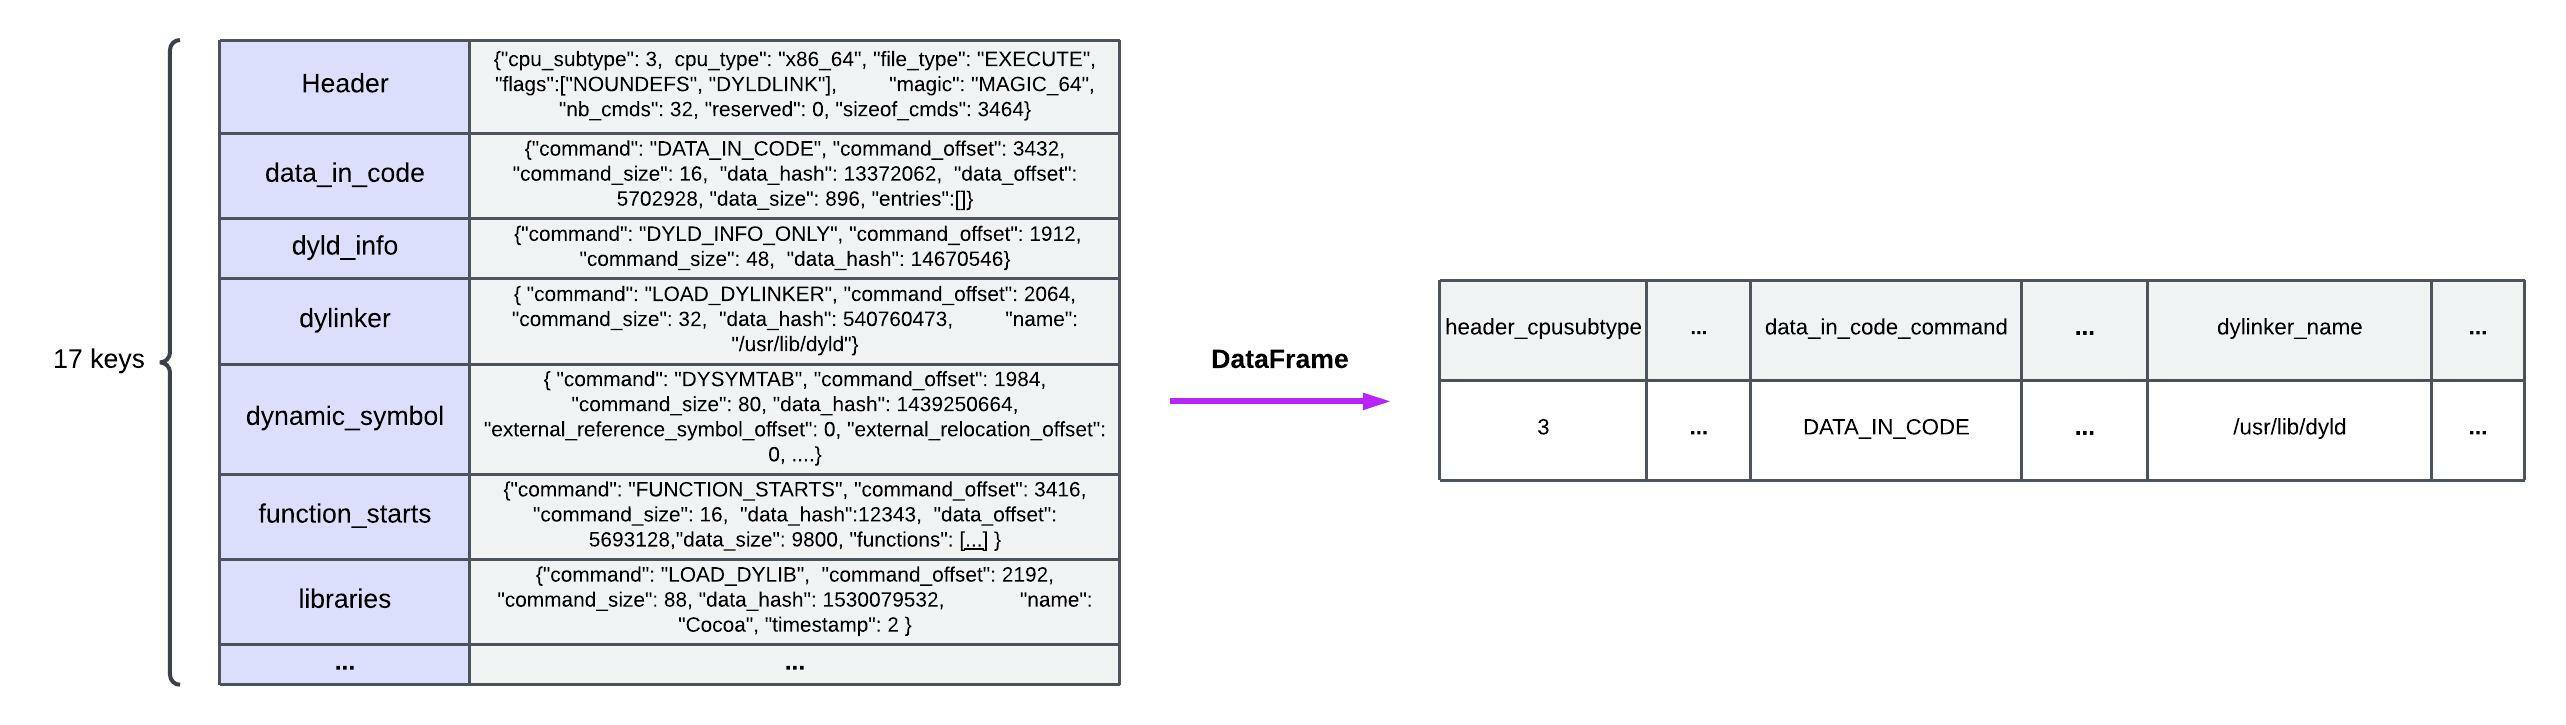

The following function gets a column in the raw data set as input, extracts all the attributes from those objects that the column contains, and produces a DataFrame that contains the same information only more explicitly.

In [7]:
# this library takes a string and converts it to the corresponding object which represents such as a list, dict, etc.
import ast

def extract_raw_features(raw_dataset , column):

  raw_features = {}
  for index , value in raw_dataset[column].items():
    
    value = str(value)
    
    if value == "nan":
      raw_features[index] = value # Nan

    else :
      value_type = ast.literal_eval(value)  
    
      if isinstance(value_type , dict):
          raw_features[index] = value_type
      
      elif isinstance(value_type , list):
            if column == 'libraries': # extract the name of the libraries which the file use.
                libraries_names = []
                for lib in value_type:
                  libraries_names.append(lib['name'])
                raw_features[index] = libraries_names

            if column == 'sections': # extract the size of all the sections in bytes of the file.
              sections_size = 0
              for section in value_type:
                  sections_size = sections_size + section['size']
              raw_features[index] = sections_size

            if column == 'segments': # extract information about the protection level for each segment in the file.
              segments = {}
              for segment in value_type:
                  segments[segment['name']] = {'init_protection' : segment['init_protection'] , 'max_protection': segment['max_protection']}
              raw_features[index] = segments

            if column == 'relocations': # extract the number of relocations that are present in that file.
              raw_features[index] = len(value_type)

            if column == 'symbols': # extract the name of the symbol in the symbol table.
                symbols_names = []
                for symbol in value_type:
                  symbols_names.append(symbol['name'])
                raw_features[index] = symbols_names
                      

  if column == 'libraries' or column == 'symbols':
    raw_features =  pd.DataFrame([raw_features]).T
    raw_features.columns = [column + "_" + "names"]
    # create a new column in the dataframe , which represent the amount of the libraries or symbols in each record
    raw_features[column + '_length'] = raw_features[column + "_" + "names"].apply(lambda x: len(x))

  elif column == 'relocations' or column == 'sections':
    raw_features =  pd.DataFrame(raw_features , index = [0]).T
    raw_features.columns = [column + "_" + "size"]
    
  else:
    raw_features =  pd.DataFrame(raw_features).T  
    raw_features.columns = [column + "_" + col for col in raw_features.columns]

  return raw_features

The following function receives as input a raw data set, iterate through its columns, and produces a list of DataFrames when finally all of them will be concatenated into one data set.

In [8]:
def get_extracted_features(raw_dataset) :
  extracted_features = []
  for column in raw_dataset.columns:
    extracted_features.append(extract_raw_features(raw_dataset , column))

  concatenated = pd.concat(extracted_features, axis="columns")
  concatenated = concatenated.applymap(str)

  for column in concatenated.columns[concatenated.isna().any()].tolist():
      concatenated[column] = concatenated[column].fillna('None')

  return concatenated

In [9]:
benign_dataset = get_extracted_features(raw_benign)
malware_dataset = get_extracted_features(raw_malware)

In [17]:
benign_dataset.head(1)

,code_signature_command,code_signature_command_offset,code_signature_command_size,code_signature_data_hash,code_signature_data_offset,code_signature_data_size,data_in_code_command,data_in_code_command_offset,data_in_code_command_size,data_in_code_data_hash,...,build_version_platform,build_version_sdk,build_version_tools,thread_command_command,thread_command_command_offset,thread_command_command_size,thread_command_count,thread_command_data_hash,thread_command_flavor,thread_command_pc
0,CODE_SIGNATURE,3928,16,1597076050,202544,10400,DATA_IN_CODE,3912,16,18446744071984815328,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [ ]:
same_columns = benign_dataset.columns.intersection(malware_dataset.columns).tolist()
# Since we want to concatenate those datasets, we must insure they have the same columns
benign_dataset = benign_dataset[same_columns]
malware_dataset = malware_dataset[same_columns]

# add the label for both datasets
benign_dataset['label'] = 0
malware_dataset['label'] = 1

Now, we have two sets of raw data (malware and benign) which are described more abstractly and clearly.
We would like to see the distribution of features and see how many of them contain unique values, and which features do not.

In [19]:
import numpy as np
import plotly.express as px
def feature_distribution_plot(raw_dataset):
  # Iterate through the data set and check for each column what types it contains and their quantities.
  features , unique_values = ([],[])
  same_value_features = []
  for (col_name,col_value) in raw_dataset.iteritems():
          features.append(col_name)
          unique_values.append(len(np.unique(col_value)))
          if(unique_values[-1] == 1):
            # add the columns that contains one value for each record in the dataset
            same_value_features.append(col_name)

  df = pd.DataFrame(dict(zip(features, unique_values)) , index = ['amount']).T.reset_index()

  fig = px.bar(df, x='index', y='amount')
  fig.update_layout(bargap=0.2)
  fig.show()

In [ ]:
feature_distribution_plot(benign_dataset)

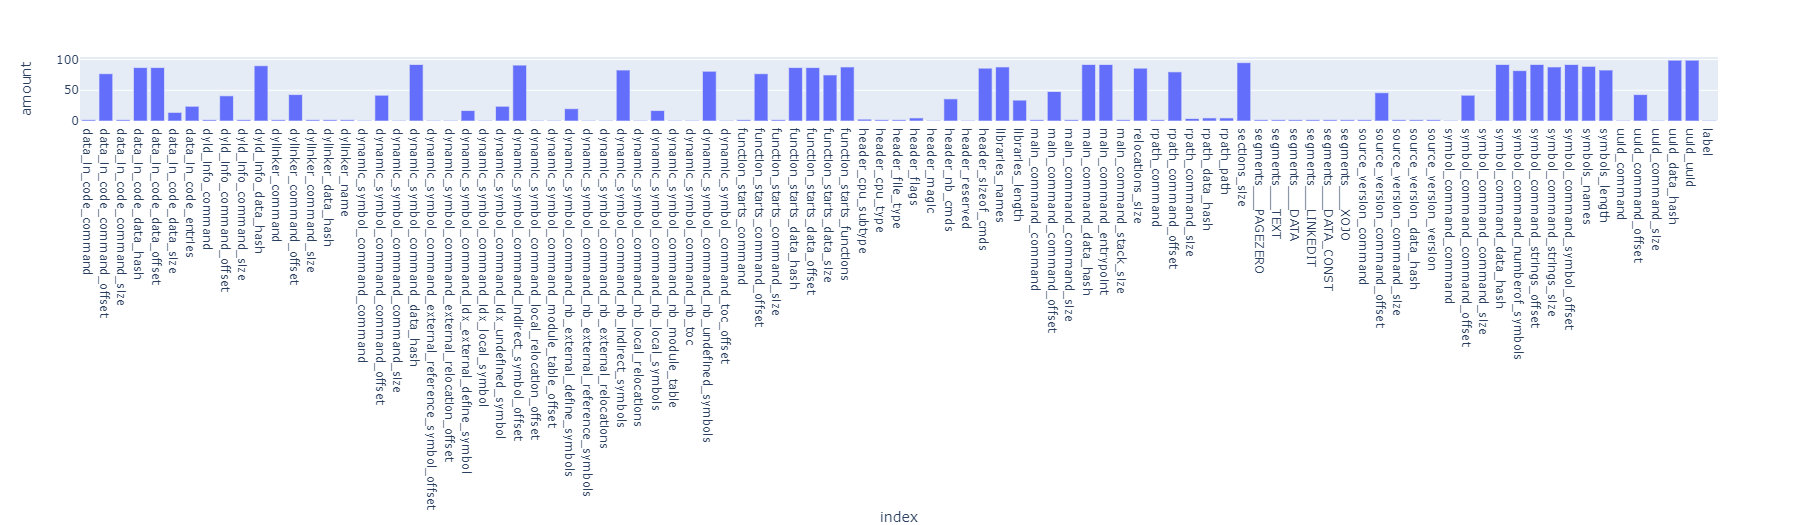

In [ ]:
feature_distribution_plot(malware_dataset)

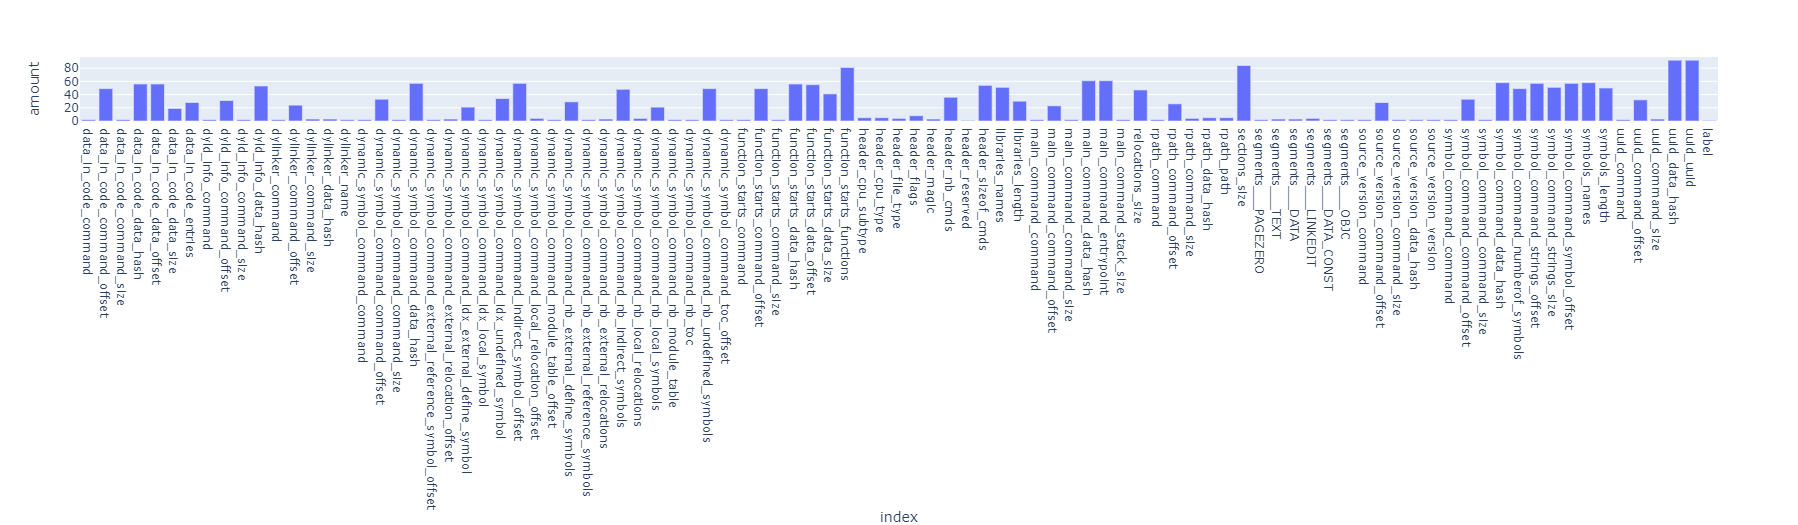

Now, the data set contains values whose type is object, even if they represent some number.
Therefore we will convert those columns which describe numerical values to their appropriate type.

In [46]:
def columns_to_numeric(dataset):
# convert all the elements in the dataset to numeric, if it is not possible to convert an element to a numeric it will be converted to NaN.
  numeric = dataset.apply(pd.to_numeric, errors='coerce')
  columns = numeric.columns[numeric.isna().sum() < dataset.shape[0]].tolist()

  #after we got the columns that can be a numeric , we convert them in the input dataset.
  dataset[columns] = dataset[columns].apply(pd.to_numeric, errors='coerce')
  return dataset

In [47]:
benign_dataset = columns_to_numeric(benign_dataset)
malware_dataset = columns_to_numeric(malware_dataset)

dataset = pd.concat([benign_dataset, malware_dataset])
dataset.to_csv("/content/drive/MyDrive/MacOSMalware/dataset.csv")

In [48]:
dataset = pd.read_csv("/content/drive/MyDrive/MacOSMalware/dataset.csv" , index_col = 0)

# Delete columns containing either 50% or more than 50% NaN Values
for column in dataset:
    if sum(dataset[column].isnull()) >= (dataset.shape[0] / 2):
        dataset.drop(column, axis=1, inplace = True) 

### Dealing with categorical features

---
In this part we will transform those columns that contain categorical values using different methods.

In [50]:
# Selecting the columns containing objects after performing the transformation.
object_columns = dataset.columns[dataset.dtypes == object]
# Search for columns that contains complex objects like dictionaries and lists. 
complex_columns = set()

for column in object_columns:
    for value in dataset[column]:
      try:
        value_type = ast.literal_eval(value)  
        if isinstance(value_type , list) or isinstance(value_type, dict):
           complex_columns.add(column)
      except:
        continue


# using XOR to determine the difference between all the columns that contain objects for those that contain complex objects.
simple_columns = list(object_columns ^ complex_columns)

<ipython-input-50-665d0f427c8c>:17: FutureWarning:

Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead



When we imported the raw data, we saw that it was possible to divide the types of categorical variables into two different groups:

1.   `Simple categorical variables`: containing a single string.
      
      such as the header file type feature :
            
          `EXECUTE`

2.   `Complex categorical variables`: containing dictionaries and lists. 
      
      such as the header flag feature :
      
          `['NOUNDEFS', 'DYLDLINK', 'TWOLEVEL', 'WEAK_DEFINES', 'BINDS_TO_WEAK', 'PIE', 'HAS_TLV_DESCRIPTORS']`
And after performing the mapping for both types of categorical variables, we will encode these columns according to their complexity level.



In [51]:
def fillnone_dataset(dataset):
  for column in dataset.columns[dataset.isna().any()].tolist():
      dataset[column] = dataset[column].fillna('None')
      return dataset

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dataset = fillnone_dataset(dataset)
# Run LabelEncoder on the simplest set of features
for column in simple_columns: 
      dataset[column] = le.fit_transform(dataset[column])

dataset[simple_columns].info()

In [64]:
complex_columns

{'data_in_code_entries',
 'function_starts_functions',
 'header_flags',
 'libraries_names',
 'segments___DATA',
 'segments___LINKEDIT',
 'segments___PAGEZERO',
 'segments___TEXT',
 'source_version_version',
 'symbols_names',
 'uuid_uuid',
 'version_min_sdk',
 'version_min_version'}

In [73]:
dataset['data_in_code_entries'][4].tolist()

["[{'length': 32, 'offset': 24436, 'type': 'JUMP_TABLE_32'}, {'length': 16, 'offset': 24848, 'type': 'JUMP_TABLE_32'}, {'length': 176, 'offset': 32208, 'type': 'JUMP_TABLE_32'}, {'length': 364, 'offset': 34244, 'type': 'JUMP_TABLE_32'}, {'length': 16, 'offset': 43444, 'type': 'JUMP_TABLE_32'}, {'length': 16, 'offset': 44628, 'type': 'JUMP_TABLE_32'}]",
 '[]']